In [1]:
import json

import solver.solver
from core.model_data import Parameters, EventTreeWithCounts
from generator.context import SNVGeneratorContext
from generator.gen import SNVModelGenerator, sample_cells_data
from stats.statistics_calculator import StatisticsCalculator

from typing import List, Tuple
import numpy as np
import random

In [2]:
class GeneratorContext(SNVGeneratorContext):
    def number_of_bins(self):
        return 1000

ctxt = GeneratorContext(p=Parameters(m=0.03, q=0.0001, e=0.001))

In [3]:
model_generator = SNVModelGenerator(ctxt)
model = model_generator.generate_model(tree_size=10)

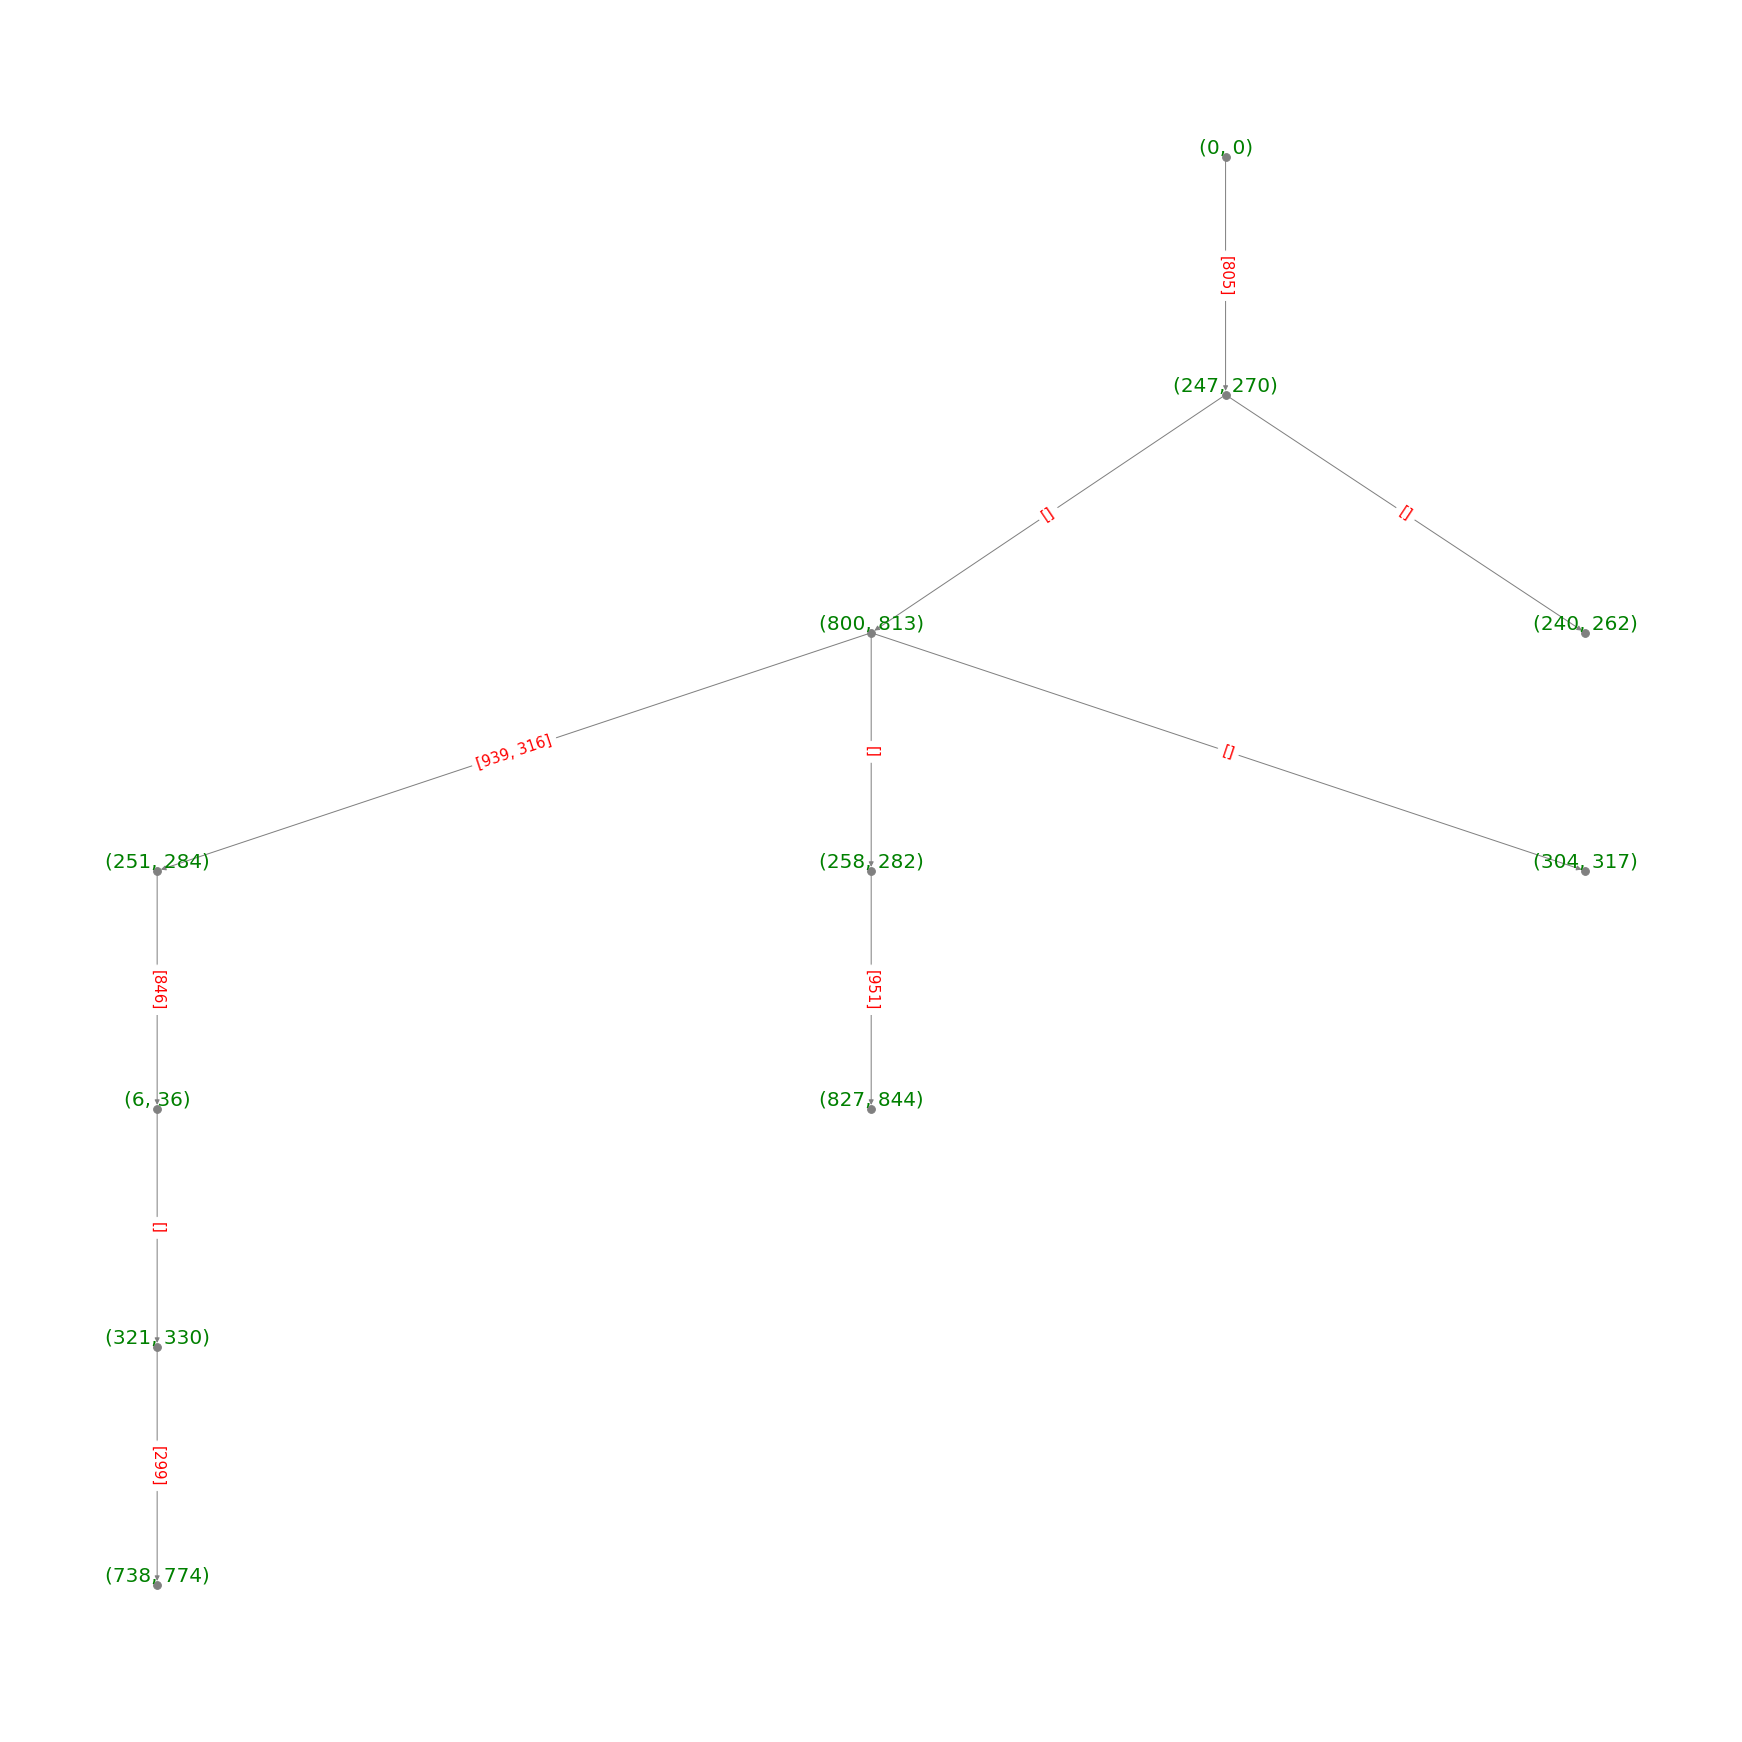

In [4]:
"""
DRAW TREE + SNVs 
"""

from matplotlib import pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx 
import json
# Draw inferred tree 
plt.figure(3, figsize=(24, 24))
pos = graphviz_layout(model.tree.cn_event_tree, prog="dot")
nx.draw(model.tree.cn_event_tree, pos=pos, with_labels=True, node_color="grey", node_size=60, verticalalignment="bottom",
        font_size=20, edge_color="grey", font_color="green")


edge_dict = {} 
for edge in model.tree.cn_event_tree.edges: 
    edge_dict[edge] = json.dumps(list(model.tree.node_to_snvs[edge[1]]))
nx.draw_networkx_edge_labels(
    model.tree.cn_event_tree, pos,
    edge_labels=edge_dict,
    font_color='red', font_size = 15
)
plt.show()

In [6]:
cells, _ = sample_cells_data(clusters=10, cluster_size=100, model=model, ctxt=ctxt, random_attachment=True)

tree_without_snvs = model.tree.__copy__()
tree_without_snvs.remove_snvs()

inferred_tree = solver.solver.solve(cells_data=cells, tree=EventTreeWithCounts(tree=tree_without_snvs, node_to_cn_profile=model.node_to_cn_profile))

2022-07-15 10:55:49,845 — solver.solver — INFO — Starting MM estimation of parameters...
2022-07-15 10:55:49,848 — solver.solver — INFO — Estimated parameters: Per allele coverage: 0.029869772750856075, sequencing error: 0.0001, read success probability: 0.5.. Starting Newton-Rhapson optimization...


/usr/local/lib/python3.9/site-packages/solver/parameters_inference.py:20: UserWarning: Can't estimate sequencing error - there are no reads for full deletions in the dataset!Setting sequencing error to 0.0001.
  warnings.warn(f"Can't estimate sequencing error - there are no reads for full deletions in the dataset!"


2022-07-15 10:55:53,656 — solver.solver — INFO — Estimated parameters: Per allele coverage: 0.029869773079423307, sequencing error: 0.0015461431555147415, read success probability: 1.3520152699027858e-10.. Inferring SNV events...
2022-07-15 10:55:56,212 — solver.ml_snv_solver — INFO — Starting SNV events inference, log-likelihood of tree with 0 SNVs: -22943.75630253562.
2022-07-15 10:55:56,218 — solver.ml_snv_solver — INFO — Choosing best location for SNV 0. Likelihood without SNV: -23.3349273598317.
2022-07-15 10:55:56,221 — solver.ml_snv_solver — INFO — Likelihood for node (240, 262) is -24.41789197582199...
2022-07-15 10:55:56,228 — solver.ml_snv_solver — INFO — Likelihood for node (247, 270) is -34.10342106607393...
2022-07-15 10:55:56,237 — solver.ml_snv_solver — INFO — Likelihood for node (800, 813) is -31.95285114705507...
2022-07-15 10:55:56,243 — solver.ml_snv_solver — INFO — Likelihood for node (738, 774) is -24.42959254369131...
2022-07-15 10:55:56,250 — solver.ml_snv_solver

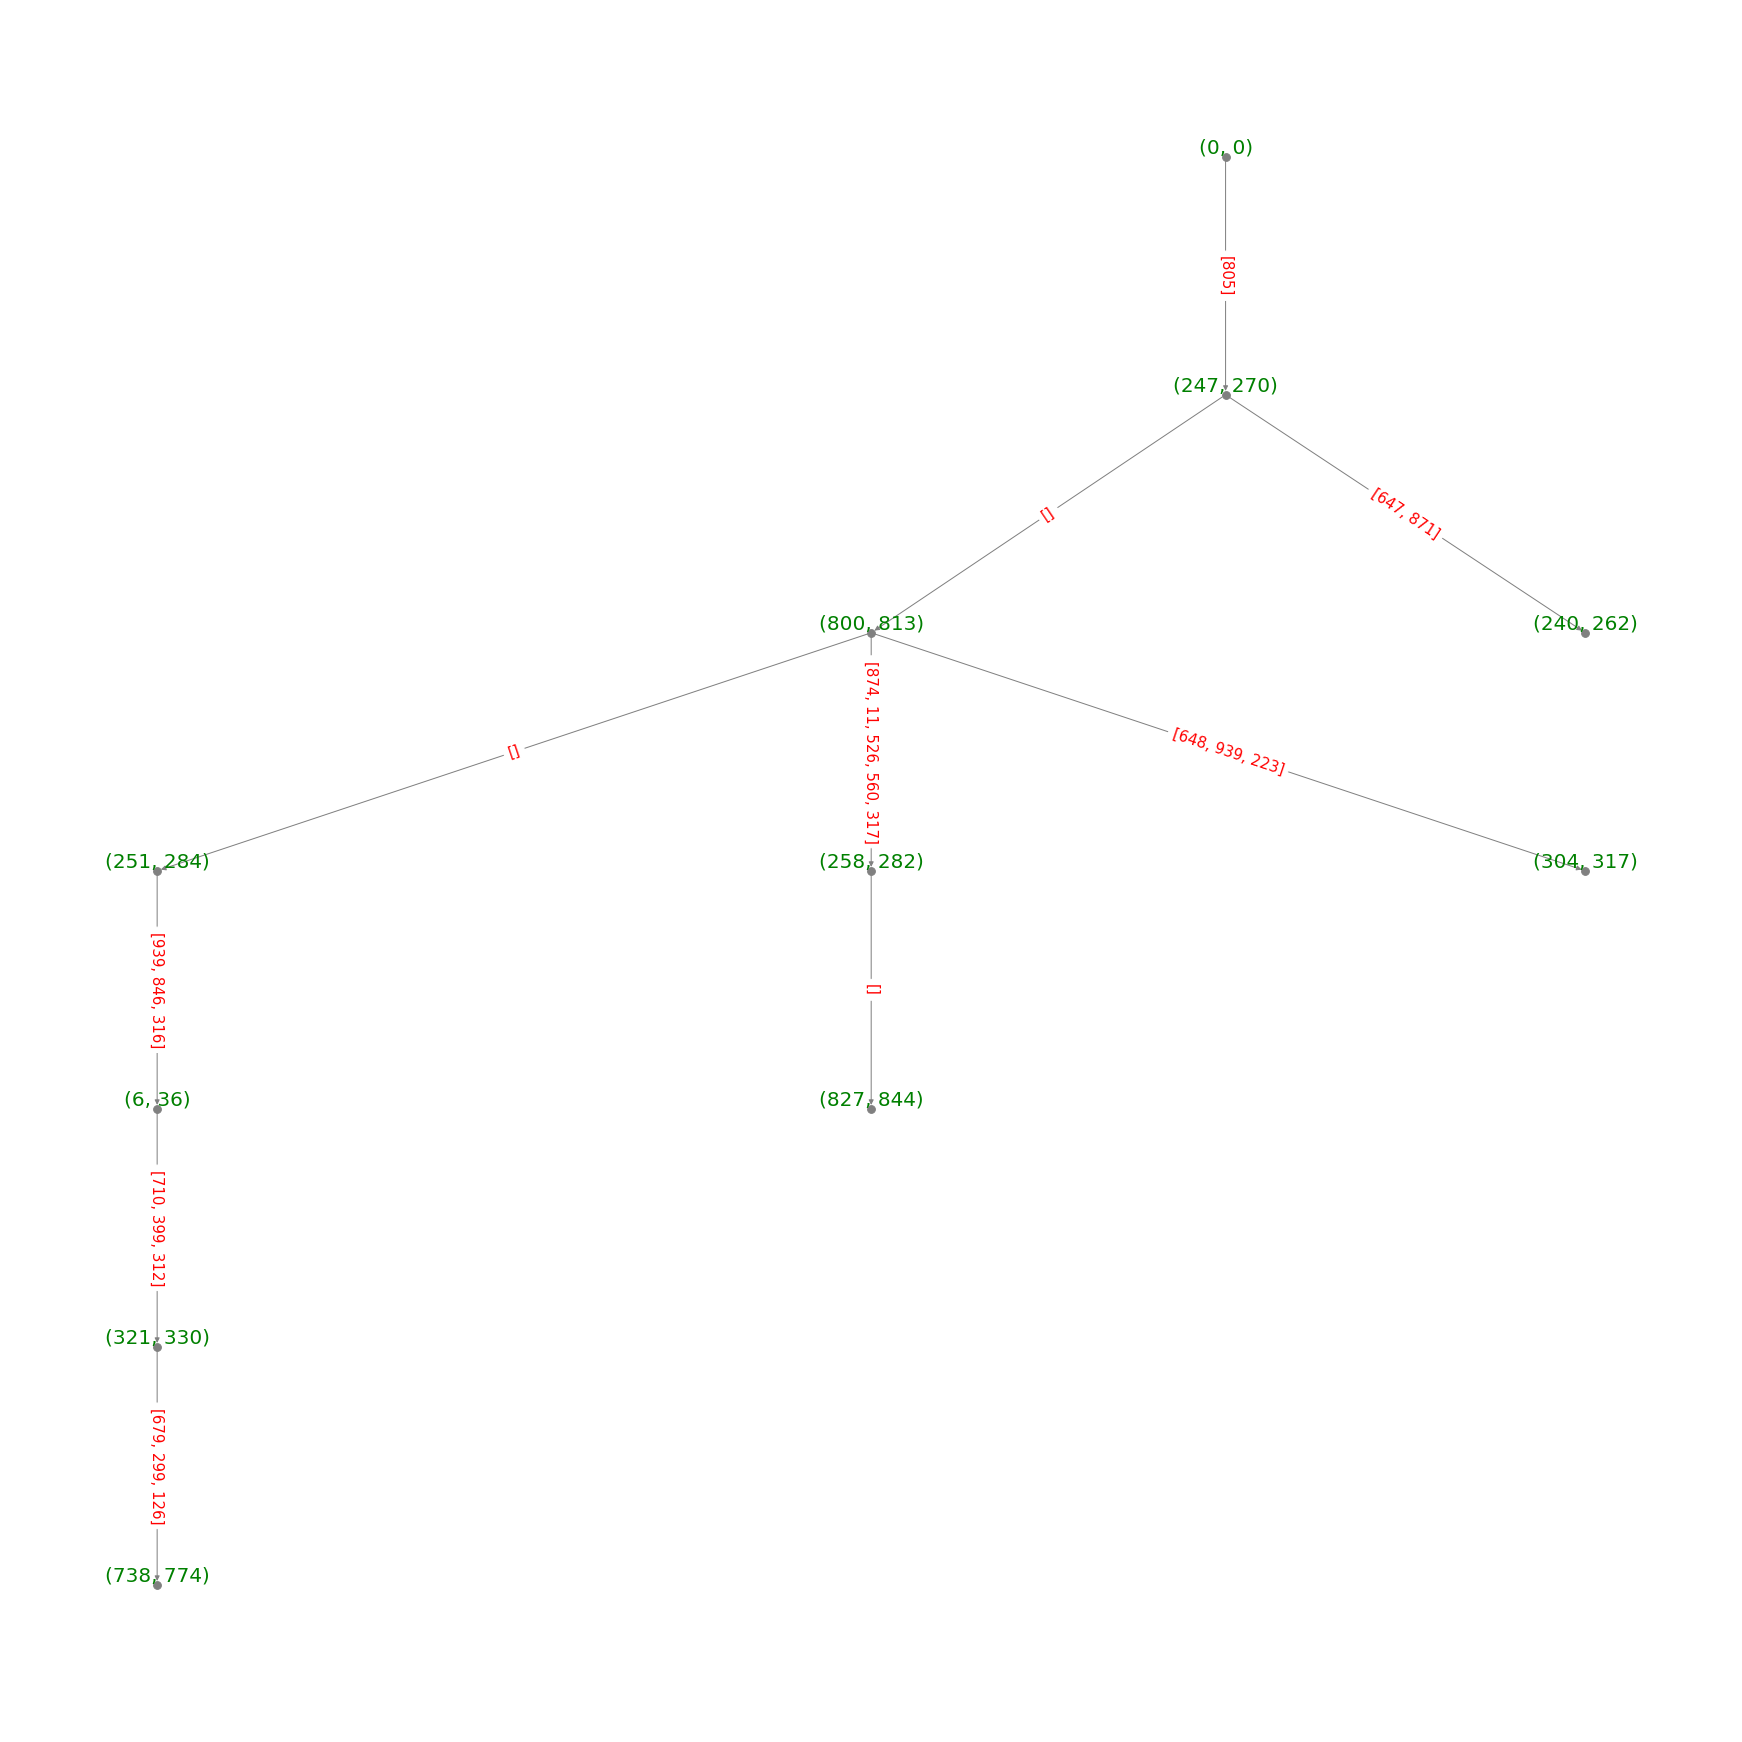

In [7]:
"""
DRAW TREE + Inferred SNVs 
"""

from matplotlib import pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx 
import json
# Draw inferred tree 
plt.figure(3, figsize=(24, 24))
pos = graphviz_layout(inferred_tree.cn_event_tree, prog="dot")
nx.draw(inferred_tree.cn_event_tree, pos=pos, with_labels=True, node_color="grey", node_size=60, verticalalignment="bottom",
        font_size=20, edge_color="grey", font_color="green")


edge_dict = {} 
for edge in inferred_tree.cn_event_tree.edges: 
    edge_dict[edge] = json.dumps(list(inferred_tree.node_to_snvs[edge[1]]))
nx.draw_networkx_edge_labels(
    inferred_tree.cn_event_tree, pos,
    edge_labels=edge_dict,
    font_color='red', font_size = 15
)
plt.show()

In [8]:
stats = StatisticsCalculator.calculate_stats(model.tree, inferred_tree)

print(json.dumps(stats))

{"SNVCallingPrecision": 0.8333333333333334, "SNVCallingSensitivity": 0.2631578947368421, "NodeSNVCallingPrecision": 0.5, "NodeSNVCallingSensitivity": 0.15, "AncestryRecall": 0.17391304347826086, "AbsoluteDifference": 20}
